(multilevel_hgf)=
# Multilevel embeding of Hierarchical Gaussian Filters

In [1]:
from numpy import loadtxt
import numpy as np
from ghgf.distribution import hgf_logp, HGFDistribution
from ghgf import load_data
from ghgf.response import total_binary_surprise
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In the previous tutorials, we discussed the use of binary and continuous Hierarchical Gaussian Filters (HGF) with 2 or 3 levels of volatility. The way we presented those models was by operating at the agent level (i.e. the observations were made by one agent, and we estimated the posterior density distribution of parameters for that agent). However, many situations in computational psychiatry and cognitive modelling will require making inferences at the population level, therefore fitting many models at the same time and estimating the density distribution of hyper-priors (see for example case studies from {cite:p}`2014:lee`). 

Luckily, we already have all the components in place to do that. We have already embedded the HGF model in a Bayesian network, where prior distributions were set over some parameters of interest. We just need to extend this approach a bit, and explicitly state that we want to fit many models (participants) at the same time, and draw their parameter values from a hyper-prior (i.e. the group-level distribution).

```{hint} Using automatic broadcasting
To estimate group-level parameters, we will have to fit multiple models at the same time, either on different input data, or on the same data with different parameters, or on different datasets with different parameters. This steps is handled natively both by the [log probability function](ghgf.distribution.hgf_logp) and the [HGFDistribution class](ghgf.distribution.HGFDistribution) using a pseudo [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) approach. When a list of *n* input time series is provided, the function will automatically apply *n* models using the provided parameters. If for some parameters an array of length *n* is provided, each model will use the n-th value as parameter. Here, we are going to rely on this feature to compute the log probability of *n* model, using *n* time series as input and *n* different parameters to test.
```

## A multilevel continuous HGF
### Simulate a dataset

Using the example of a hierarchical Gaussian Random Walk that we depicted in the {ref}`theory` section, we are going to us this generative model to simulate 8 random walks using known parameters and infer afterhand the group-level value of $\omega_1$ from this dataset. The generative model is given by:

$$
\omega_1, \omega_2 = -10.0  \\
\mu_1, \mu_2 = 0.0  \\
u^{(k)} \sim \mathcal{N}(x_1^{(k)} , 1e-4) \\
x_1^{(k)} \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)}, \exp(\kappa_1 x_2^{(k)} + \omega_1)) \\
x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \exp(\omega_2)) \\
$$

```{note}
Here we are usig a noisy input node.
```

In [2]:
np.random.seed(123)
n_data = 8
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1, omega_2 = -10.0, -10.0
    mu_1, mu_2 = 0.0, 0.0

    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(input_data)

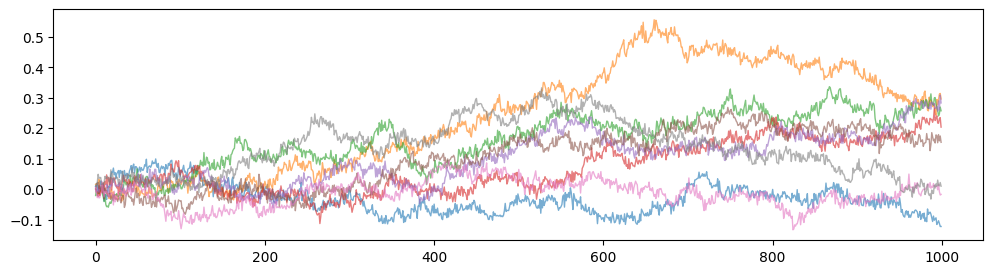

In [3]:
_, axs = plt.subplots(figsize=(12, 3))
for rw in dataset:
    axs.plot(rw, alpha=.6, linewidth=1)

### Model

Here, we want to estimate the group-level value of $\omega_1$ parameter. For each *participant*, the value will be drawn from a hyper-prior using this structure:

$$
\mu_1 \sim \mathcal{N}(\mu=0.0, \sigma=10.0)  \\
\sigma_1 \sim \mathcal{HalfCauchy}(\beta=2.0)  \\
\lambda \sim \mathcal{N}(\mu=0.0, \sigma=1.0) \\
\omega_i = \mu_1 + \sigma_1 * \lambda  \\
u_{i} \sim \mathcal{HGF}(\omega_1=\omega_i, \omega_2=-10.0)
$$
with $i \in {1,...,8}$.

```{note}
We are using a non-centered parametriztion to avoid invalid samples caused by [Neal's funnel](https://num.pyro.ai/en/stable/examples/funnel.html) {cite}`neal:2003`.
```

In [4]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [5]:
with pm.Model() as model:
    
    # Hypterpriors
    #-------------
    mu_omega_1 = pm.Normal("mu_omega_1", mu=0, sigma=10.0)
    sigma_omega_1 = pm.HalfCauchy("sigma_omega_1", 2)
    
    # Priors
    #-------
    offset = pm.Normal("offset", 0, 1, shape=n_data)
    omega_1 = pm.Deterministic("omega_1", mu_omega_1 + offset * sigma_omega_1)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

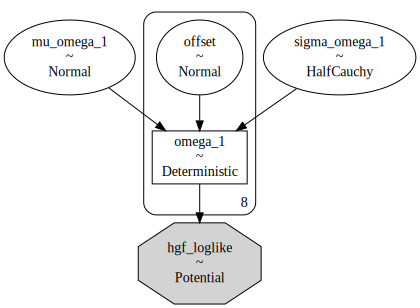

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_omega_1, sigma_omega_1, offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


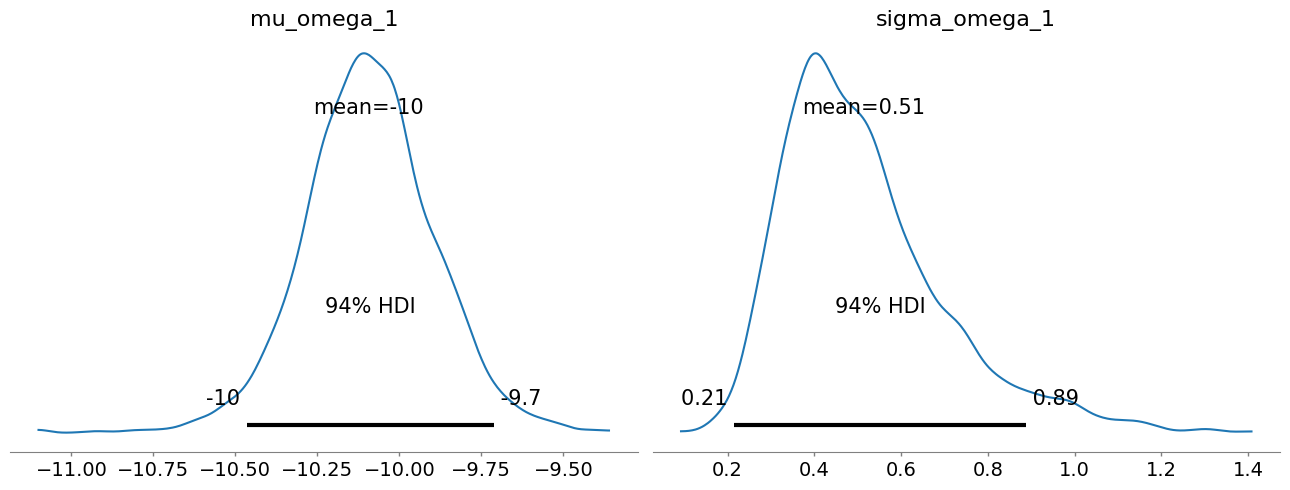

In [8]:
az.plot_posterior(idata, var_names=["mu_omega_1", "sigma_omega_1"], figsize=(13, 5));
plt.tight_layout()

As expected, the highest density aroud the group-level mean estimate inlcude `10.0`, the real value.

## A multilevel binary HGF

### Simulate a dataset

In [9]:
np.random.seed(123)
n_data = 5
dataset = []
for participant in range(n_data):
    input_data = []
    omega_2 = -2.0
    mu_2 = 0.0

    for i in range(500):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        s2 = 1/(1+np.exp(-mu_2))  # sigmoid function
        u = np.random.binomial(n=1, p=s2)       
        input_data.append(float(u))

    dataset.append(input_data)

### Without hyper-priors

In [10]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=dataset,
    response_function=total_binary_surprise,
)

In [11]:
from pymc.math import clip

with pm.Model() as two_levels_binary_hgf:
    
    # Hypterpriors
    #-------------
    mu_omega_1 = pm.Uniform("mu_omega_1", -5, 2)
    sigma_omega_1 = pm.HalfCauchy("sigma_omega_1", 2)
    
    # Priors
    #-------
    offset = pm.Normal("offset", 0, 1, shape=n_data)
    omega_2 = pm.Deterministic("omega_2", mu_omega_1 + offset * sigma_omega_1)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.nan,
            omega_2=omega_2,
            omega_input=jnp.nan,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.nan,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

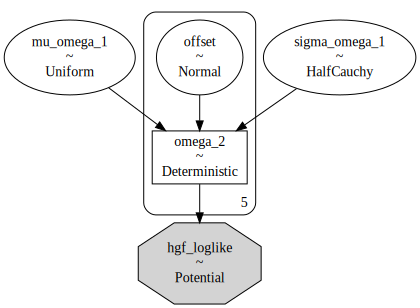

In [12]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [13]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_omega_1, sigma_omega_1, offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


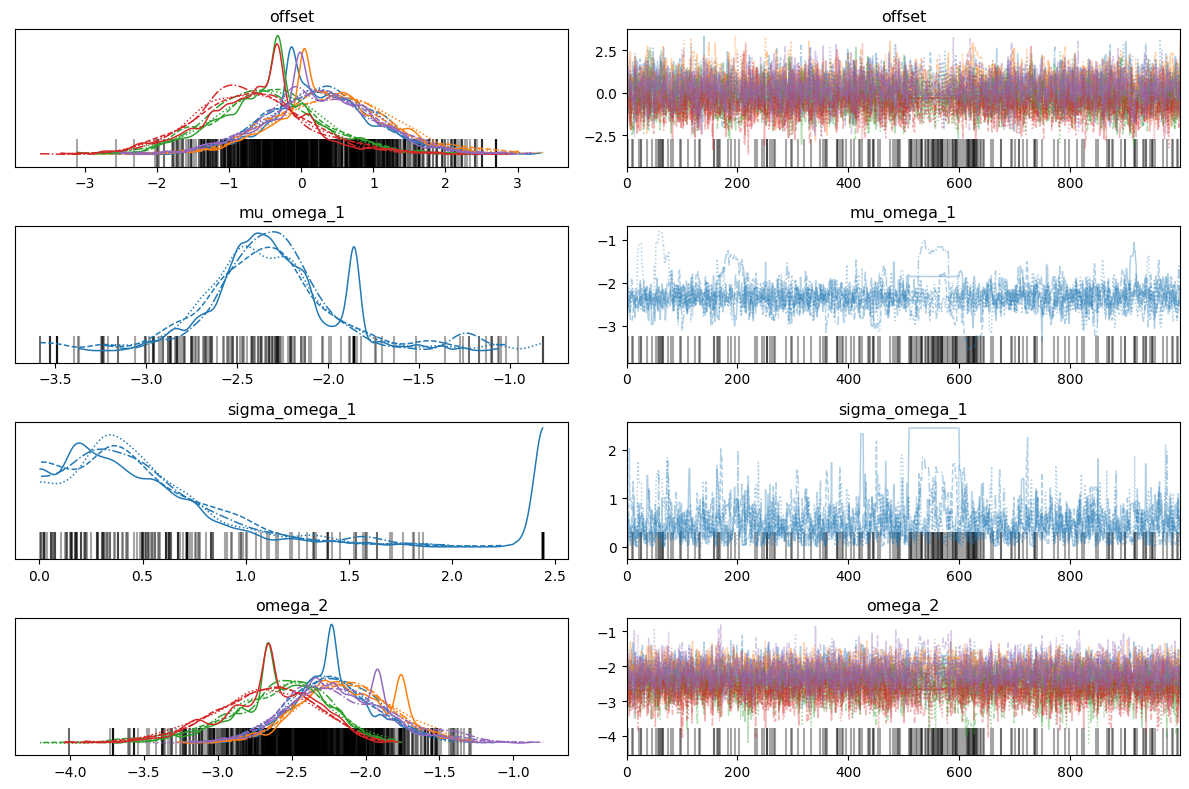

In [14]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()